In [1]:
import iminuit
from icecube import icetray, dataio, dataclasses, simclasses, clsim
from icecube.icetray import I3Units, OMKey, I3Frame
from icecube.dataclasses import ModuleKey
from os.path import expandvars
import numpy as np
import matplotlib.pylab as plt
import argparse
from scipy import stats
#from scipy.optimize import minimize
from scipy.stats.distributions import chi2
from likelihoodHelpers import log_likelihood_biGauss, log_likelihood_doublePeak, likelihood_ratio_doublePeak, likelihood_ratio_biGauss, biGauss, double_peak
import scipy
import csv
import corner

In [2]:
def plot_condition(condition, vals, recoPulse_timeList, recoPulse_chargeList):
    if condition:
        
        '''
        Calculating the mean and removing the tails
        '''

        #mean = recoPulse_timeList.mean()
        mean = sum(recoPulse_timeList*recoPulse_chargeList)/sum(recoPulse_chargeList) #mean is weighted
        select_time = recoPulse_timeList[(recoPulse_timeList > mean-50) & (recoPulse_timeList < mean+50)]
        select_charge = recoPulse_chargeList[(recoPulse_timeList > mean-50) & (recoPulse_timeList < mean+50)]
        #print('SELECT CHARGE', select_charge, select_time, mean, recoPulse_timeList, recoPulse_chargeList)

        mean_select_time = sum(select_time*select_charge)/sum(select_charge)
        max_hitTimes = recoPulse_timeList[(recoPulse_timeList > (mean_select_time-100))&(recoPulse_timeList < (mean_select_time+100))]
        max_charge = recoPulse_chargeList[(recoPulse_timeList > (mean_select_time-100))&(recoPulse_timeList < (mean_select_time+100))]

        #Shifting mean to zero
        max_hitTimes_mean = sum(max_hitTimes*max_charge)/sum(max_charge)
        timestamps = max_hitTimes - max_hitTimes_mean
        final_mean = sum(timestamps*max_charge)/sum(max_charge)

        '''
        Histogramming the data from simulation
        '''
        print('Now Histogramming')
        bins = np.arange(min(timestamps), max(timestamps), 3)
        num, bin_edges = np.histogram(timestamps, bins=bins, weights=max_charge)
        bin_centers = (bin_edges[:-1]+bin_edges[1:])/2

        num_ampRatio = num/max(num)

        #removing bins which are <1/5 the max(num), removing the tails this way.
        entries_in_bins = num[num_ampRatio > 0.2]
        bin_centers = bin_centers[num_ampRatio > 0.2]
    
        maxBinCenter = max(bin_centers)

        '''
        (x, y) values for the fit
        '''
        #x = bin_centers
        x = np.linspace(min(bin_centers)-30, max(bin_centers)+30, 1000)
        y_biGauss = biGauss(x, vals_single[1], vals_single[2], vals_single[3], vals_single[4])
        y_doublePeak = double_peak(x, vals[1], vals[2], vals[3], vals[4], 
                                   vals[5], vals[6], vals[7], vals[8])

        plt.figure(figsize=(10,9))
        _ = plt.hist(timestamps, bins=bins, weights=max_charge, histtype='step', linewidth = 5)
        plt.plot(x, y_biGauss, '--', c = 'k', label = 'bigauss', linewidth=3)
        plt.plot(x, y_doublePeak, '--', c = 'r', label = 'double bigauss', linewidth=3)
        plt.axvline(x=vals[1], c='orange', label='Postion of First Gaussian')
        plt.axvline(x=vals[5], c='g', label='Postion of Second Gaussian')
        plt.axhline(y=vals[4], c='orange', label='Amplitude of First Gaussian')
        plt.axhline(y=vals[8], c='g', label='Amplitude of Second gaussian')
        plt.legend()
        plt.xlabel('Time(ns)', fontsize = 16)
        plt.title('Time Difference - ' +str(tDiff) + ' File num - ' + str(i) + ' Frame - ' + str(frame_num) + ' ' + str(omkey), fontsize=14)                       

In [24]:
'''
Reading the output file
'''
timeDifferences_t = ([])
timeDifferences_e = ([])

ampRatio_t = ([])
ampRatio_e = ([])

widthRatio_t = ([])
widthRatio_e = ([])

skewnessRatio_t = ([])
skewnessRatio_e = ([])

LRR_t = ([])
LRR_e = ([])

for i in range(0, 2000):
    print(i)
    readFile = dataio.I3File('/data/p-one/akatil/step_6_analysis/NuTau_NuE_20Events_update3/step_6_'+str(i)+'_parameters.i3.gz')
    frame_num = 0
    for frame in readFile:
        mctree = frame["I3MCTree"]
        primary = mctree.primaries
        lepton = dataclasses.I3MCTree.first_child(mctree, primary[0].id)
        params = frame['Parameters_doublePeak']
        params_single = frame['Parameters_biGauss']
        recoPulseMap = frame['I3RecoPulses']
        
        for omkey in params.keys():
            recoPulseList = recoPulseMap[omkey]
            recoPulse_timeList = np.array([recoPulse.time for recoPulse in recoPulseList])
            recoPulse_chargeList = np.array([recoPulse.charge for recoPulse in recoPulseList])
            vals = params[omkey]
            vals_single = params_single[omkey]
            
            tDiff = abs(vals[5]-vals[1])
            wRatio = abs(vals[2]-vals[6])
            aRatio = vals[4]/vals[8]
            lRatio = 2*abs(vals_single[0]-vals[0])
            skewRatio = abs(vals[3]-vals[7])
            
            if vals[0] != vals[0] or vals_single[0]!=vals_single[0]:
                print('Found a nan')
                print(vals_single[0], vals[0])
            
            if lepton.type == 15 or lepton.type == -15:
                timeDifferences_t = np.append(timeDifferences_t, tDiff)
                widthRatio_t = np.append(widthRatio_t, wRatio)
                ampRatio_t = np.append(ampRatio_t, aRatio)
                #plot_condition(aRatio>2000, vals, recoPulse_timeList, recoPulse_chargeList)
                LRR_t = np.append(LRR_t, lRatio)
                skewnessRatio_t = np.append(skewnessRatio_t, skewRatio)
            else:#if lepton.type == 11 or lepton.type == -11:
                timeDifferences_e = np.append(timeDifferences_e, tDiff)
                widthRatio_e = np.append(widthRatio_e, wRatio)
                #plot_condition(lRatio>2000, vals, recoPulse_timeList, recoPulse_chargeList)
                ampRatio_e = np.append(ampRatio_e, aRatio)
                LRR_e = np.append(LRR_e, lRatio)
                skewnessRatio_e = np.append(skewnessRatio_e, skewRatio)
        frame_num = frame_num+1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999


In [4]:
import sys
sys.path.insert(1, '/home/users/akatil/P-ONE/git/PONE_NuTau/Graphing/')
import plots

In [6]:
params = [timeDifferences_t, widthRatio_t, skewnessRatio_t, ampRatio_t, LRR_t, 
          timeDifferences_e, widthRatio_e, skewnessRatio_e, ampRatio_e, LRR_e]

In [7]:
p = plots.plots(params)

Will plot some pretty plots using corner and matplotlib.pyplot


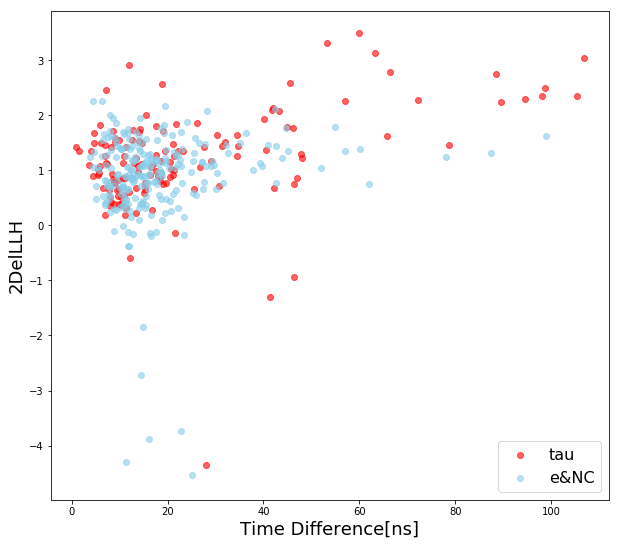

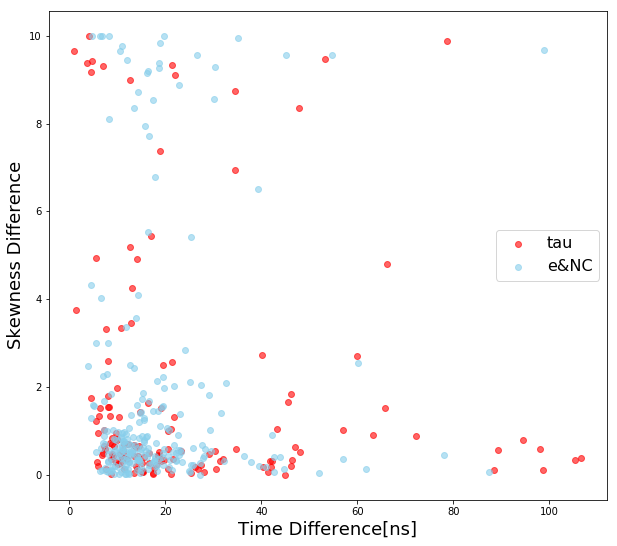

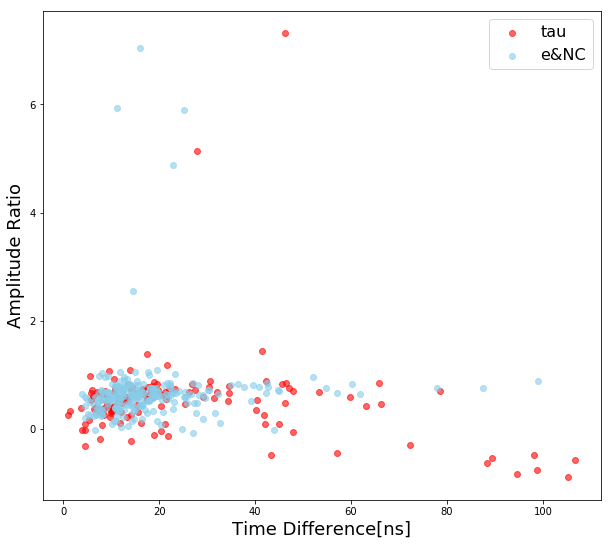

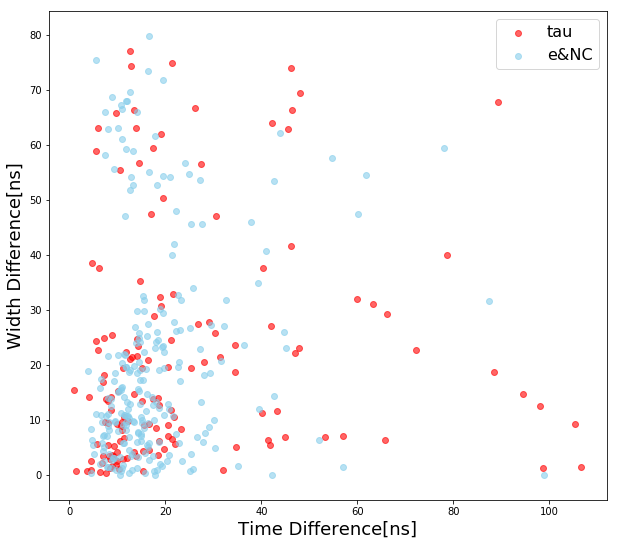

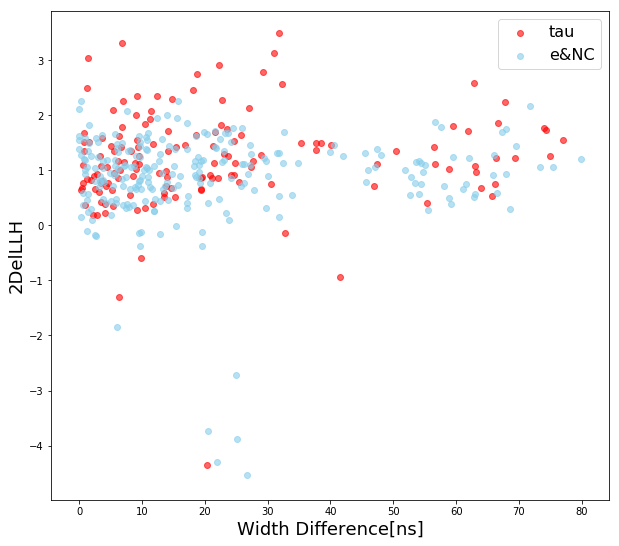

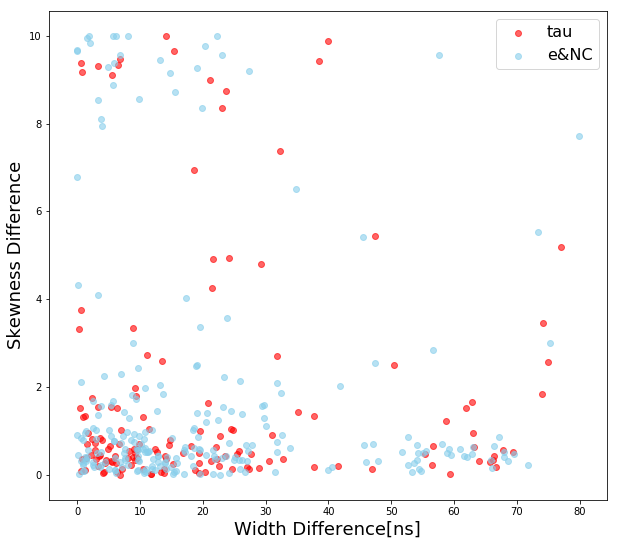

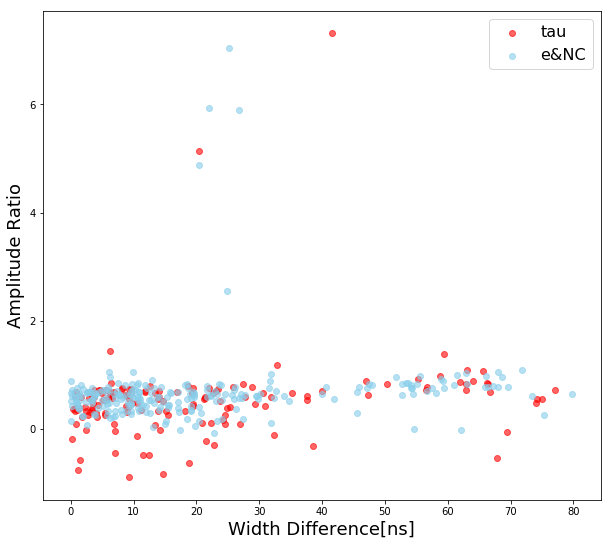

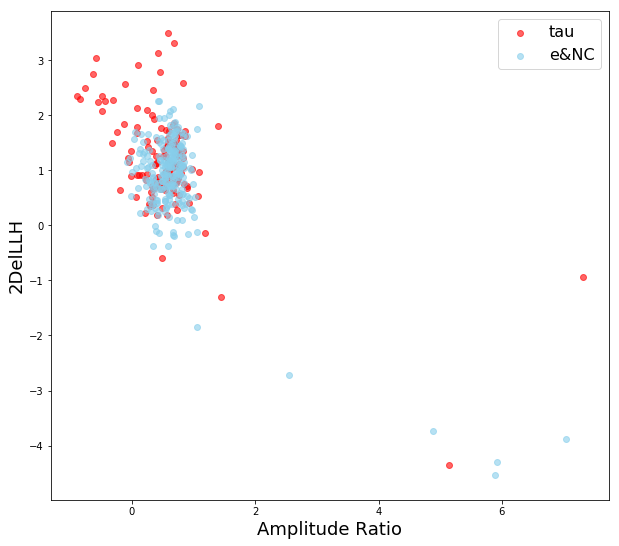

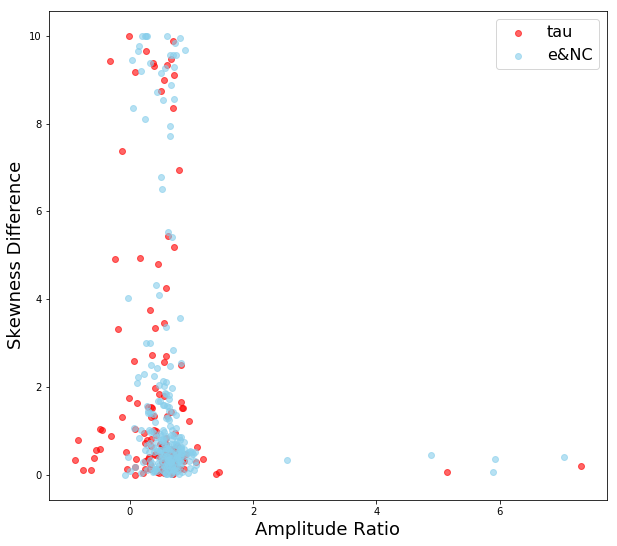

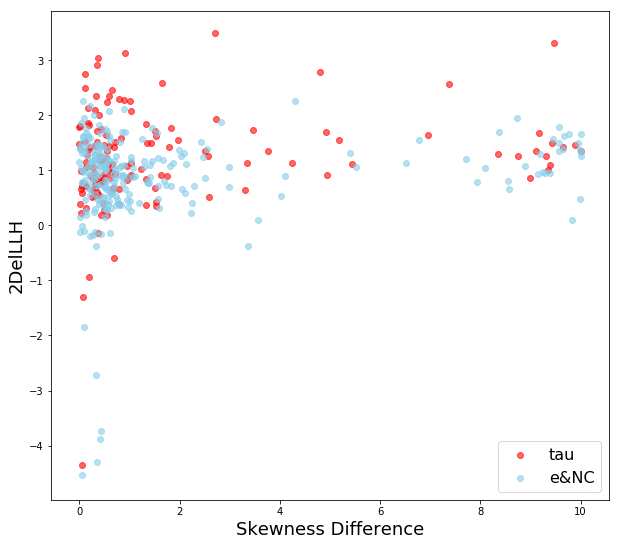

In [8]:
p.scatter(log_amp=True, log_LLH=True)

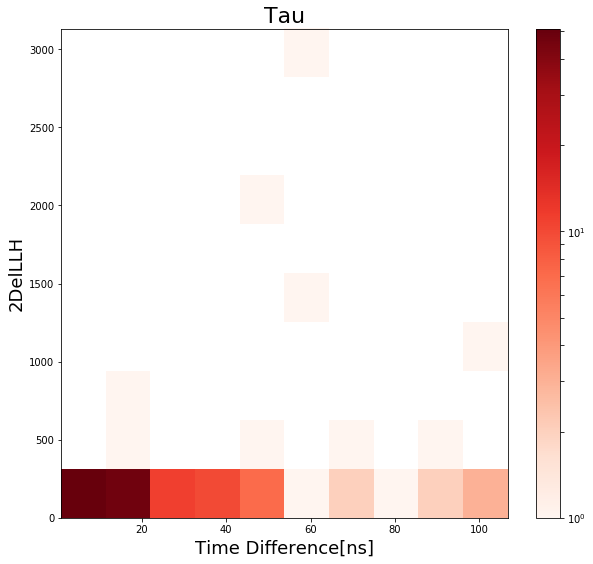

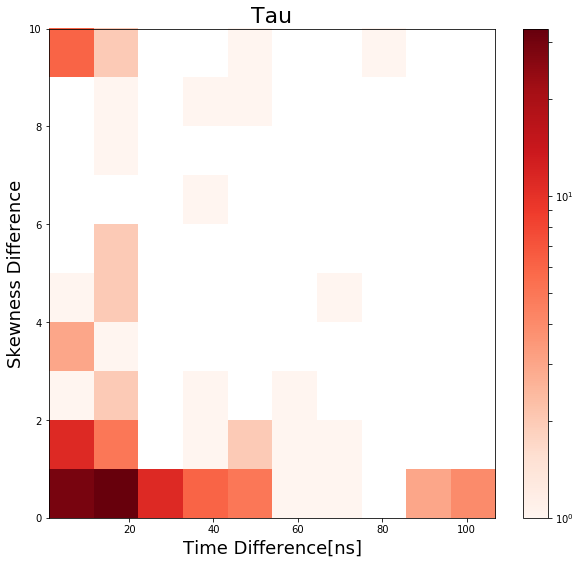

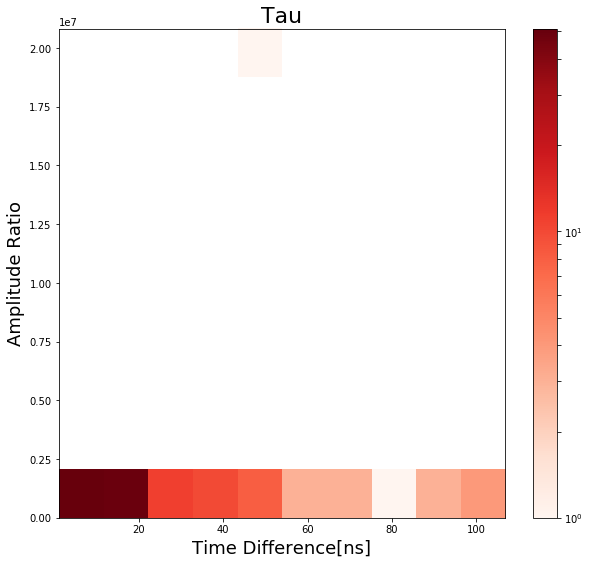

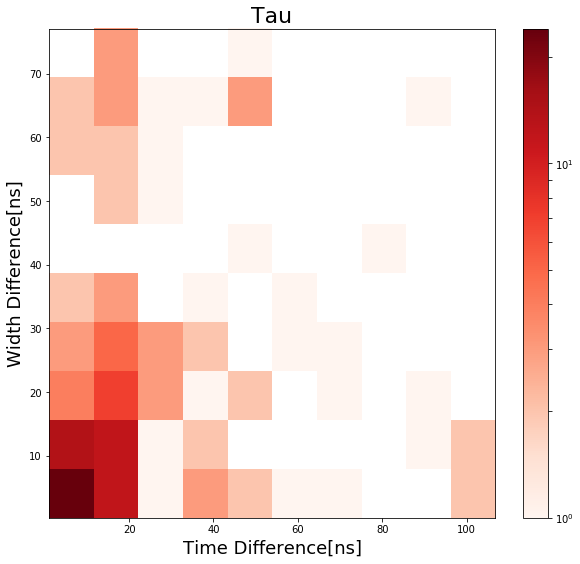

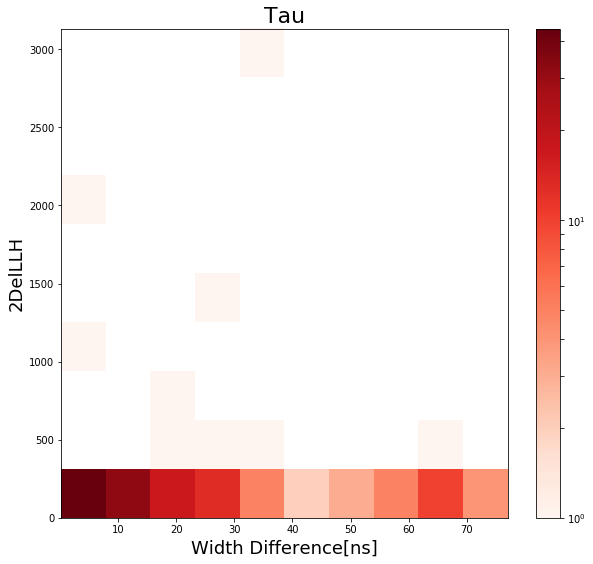

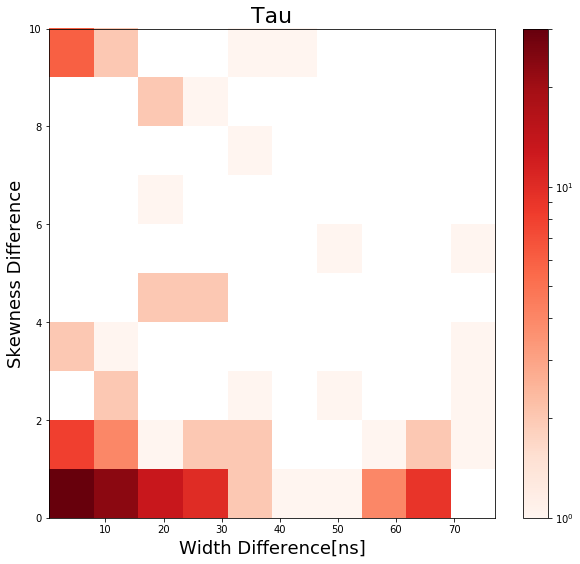

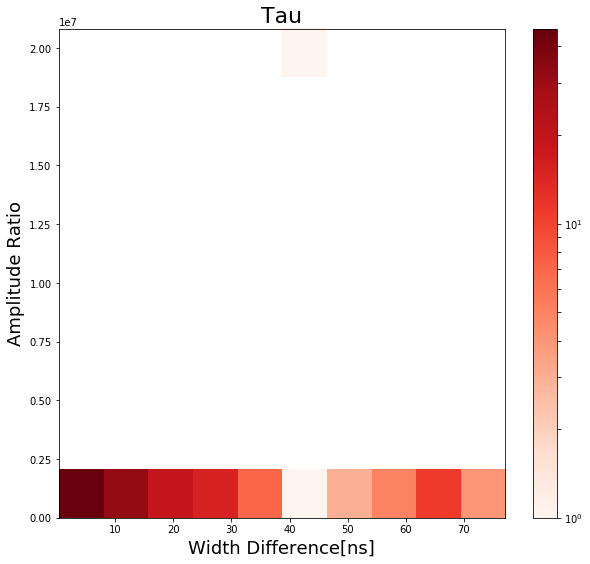

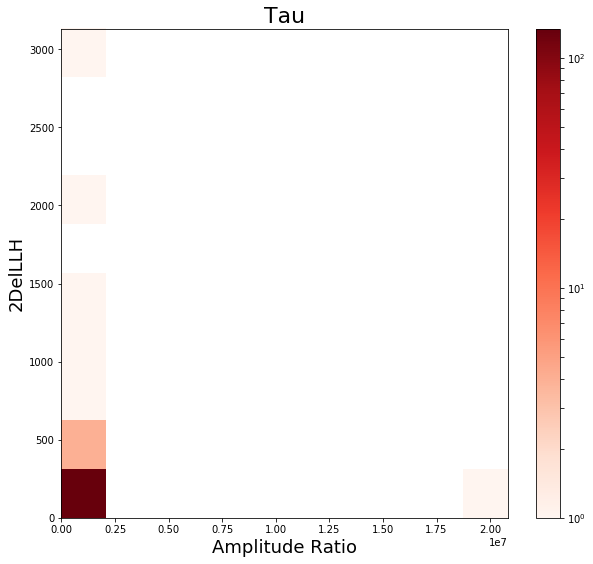

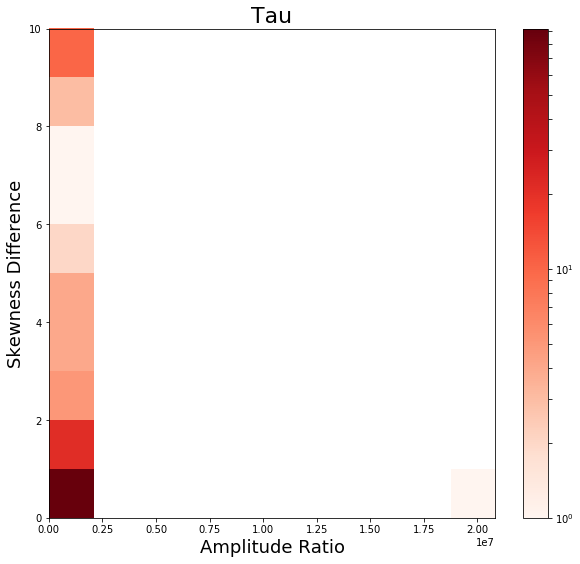

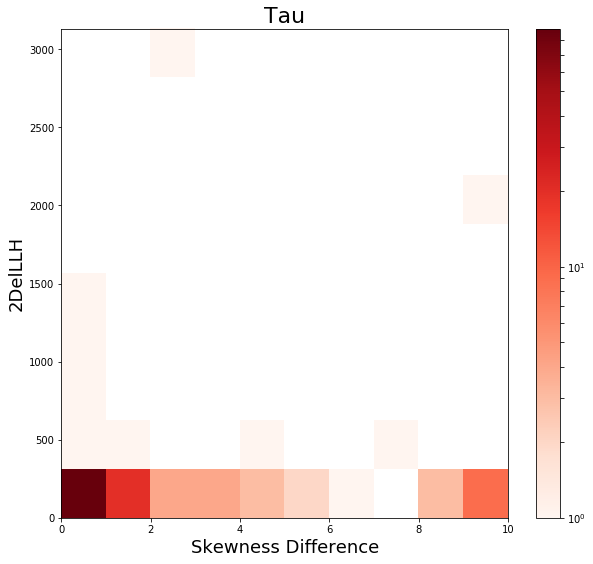

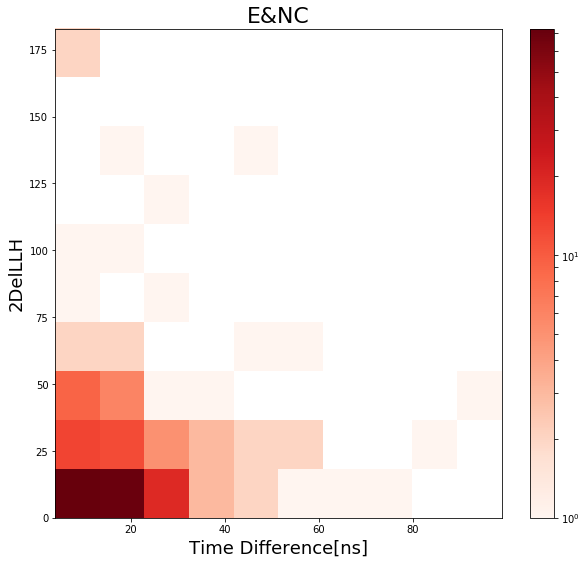

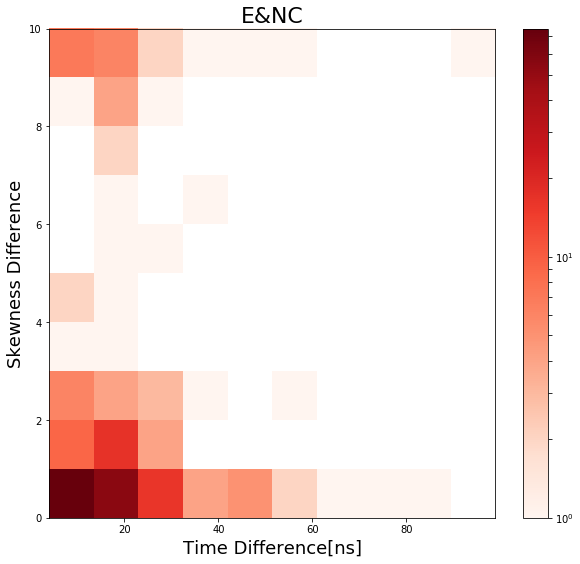

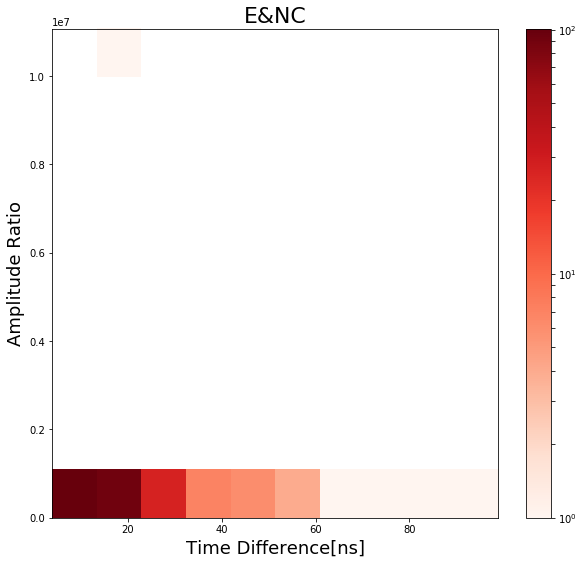

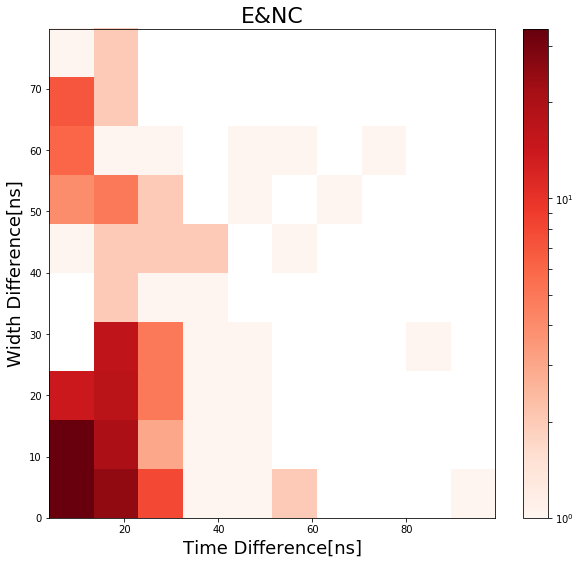

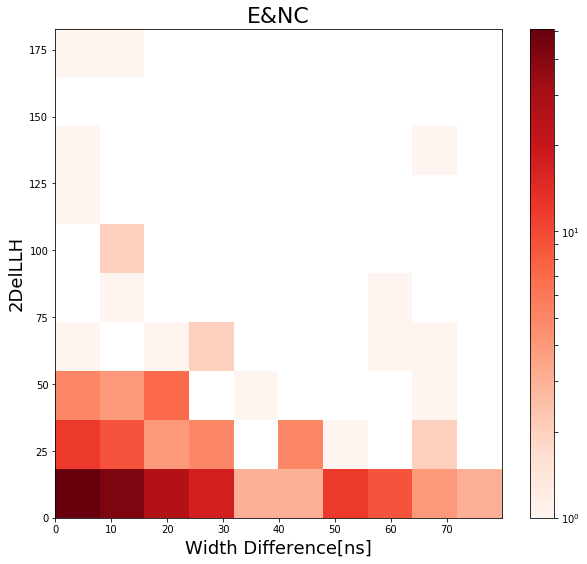

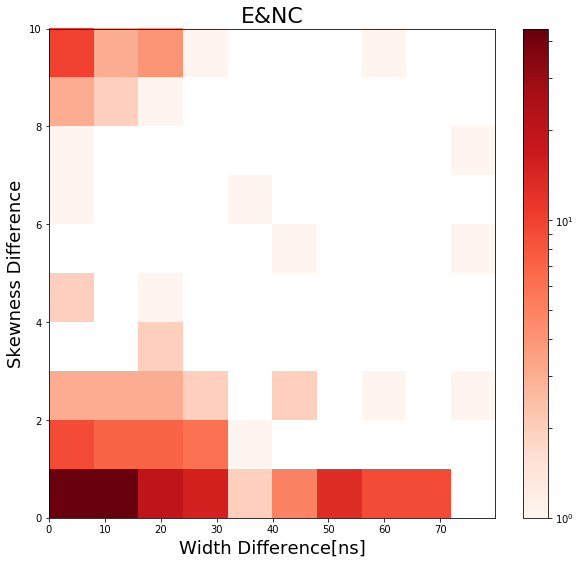

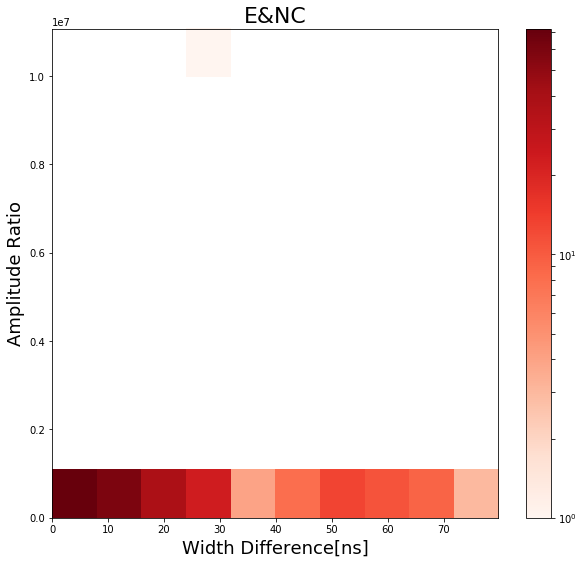

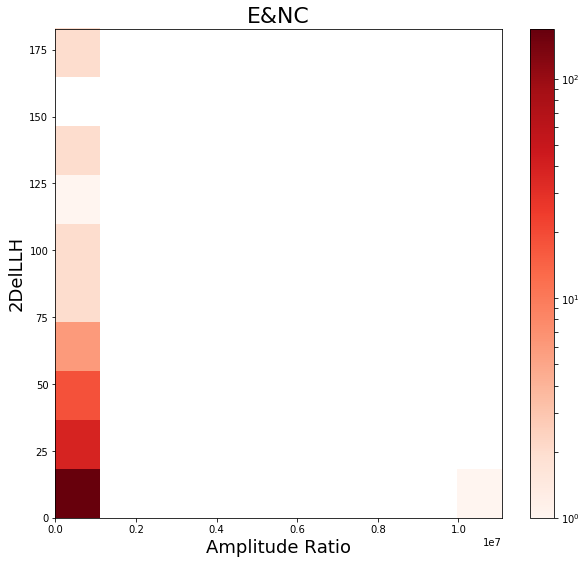

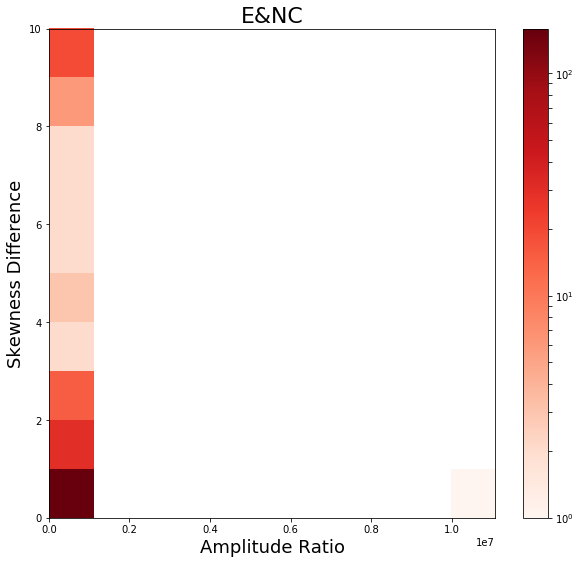

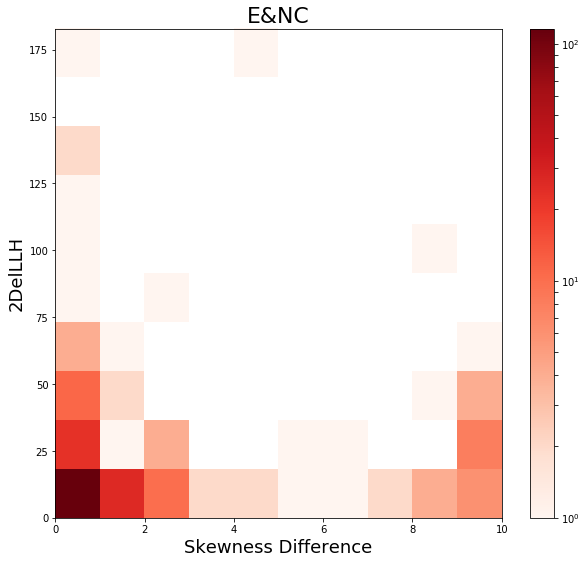

In [9]:
p.hist2d()

In [25]:
LRR_t[LRR_t == 0].shape

(0,)

In [26]:
LRR_e[LRR_e == 0].shape

(0,)

In [4]:
def data_log_Bool(bool, tDiff, wRatio, aRatio, sRatio, lRatio):
    if bool == True:
        return np.log10(np.vstack([tDiff, wRatio, aRatio, sRatio, lRatio]).T)
    else:
        return np.vstack([tDiff, wRatio, aRatio, sRatio, lRatio]).T

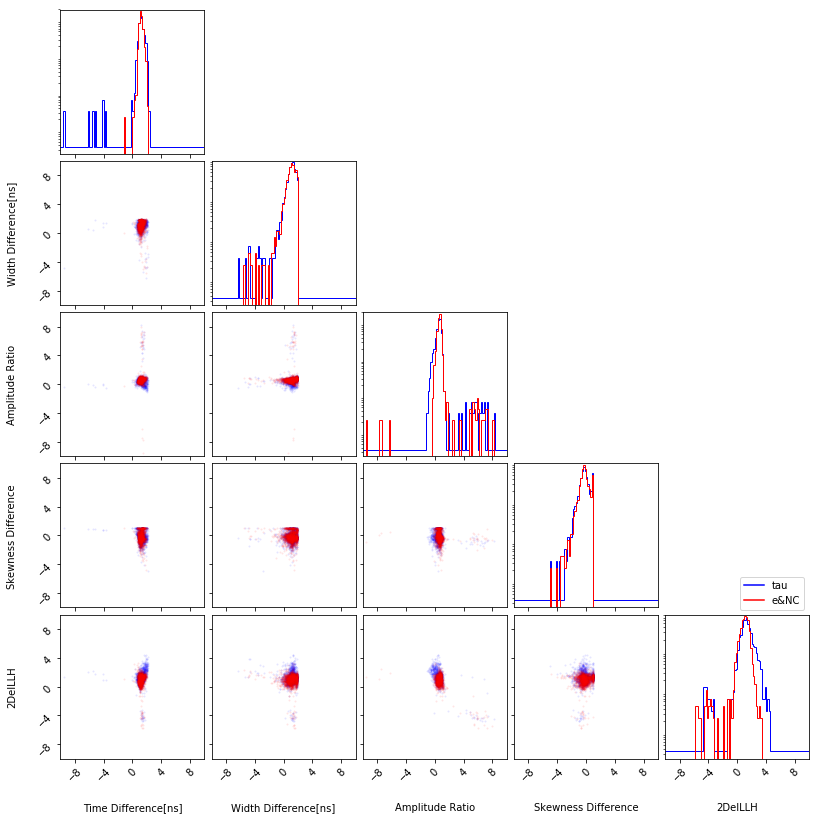

In [26]:
log_bool = True

bool_tau = (timeDifferences_t>=-100)#&(LRR_t>=2)#&(widthRatio_t>=1)&(ampRatio_t>=1)&(skewnessRatio_t>=1)&(LRR_t>=1)
tDiff_t = timeDifferences_t[bool_tau]
wRatio_t = widthRatio_t[bool_tau]
aRatio_t = ampRatio_t[bool_tau]
sRatio_t = skewnessRatio_t[bool_tau]
lRatio_t = LRR_t[bool_tau]
data_tau = data_log_Bool(log_bool, tDiff_t, wRatio_t, aRatio_t, sRatio_t, lRatio_t)

bool_e = (timeDifferences_e>=-100)#&(LRR_e>=2)#&(widthRatio_e>=1)&(ampRatio_e>=1)&(skewnessRatio_e>=1)&(LRR_e>=1)
tDiff_e = timeDifferences_e[bool_e]
wRatio_e = widthRatio_e[bool_e]
aRatio_e = ampRatio_e[bool_e]
sRatio_t = skewnessRatio_t[bool_tau]
lRatio_t = LRR_t[bool_tau]
data_e = data_log_Bool(log_bool, tDiff_e, wRatio_e, aRatio_e, skewnessRatio_e[bool_e], LRR_e[bool_e])

bins = (100, 100, 100, 100, 100)
range_cust = ((-10, 10), (-10, 10), (-10, 10), (-10, 10), (-10, 10))

labels = ['Time Difference[ns]', 'Width Difference[ns]', 'Amplitude Ratio', 'Skewness Difference', '2DelLLH']
# Plot it.
figure = corner.corner(data_tau, plot_contours=False, scale_hist=False, labels=labels,
                        plot_density = False, color='b', hist_kwargs={"normed":True,
                                                                     "log":True}, label='tau', bins=bins, range=range_cust)
corner.corner(data_e, fig=figure, plot_contours=False, scale_hist=False, labels=labels,
                        plot_density = False, color='r', hist_kwargs={"normed":True,
                                                                     "log":True}, label='e&NC', bins=bins, range=range_cust)
import matplotlib.lines as mlines

red_line = mlines.Line2D([], [], color='blue', label='tau')
blue_line = mlines.Line2D([], [], color='red', label='e&NC')
plt.legend(handles=[red_line,blue_line], bbox_to_anchor=(0., 1.0, 1., .0), loc=4)
plt.show()

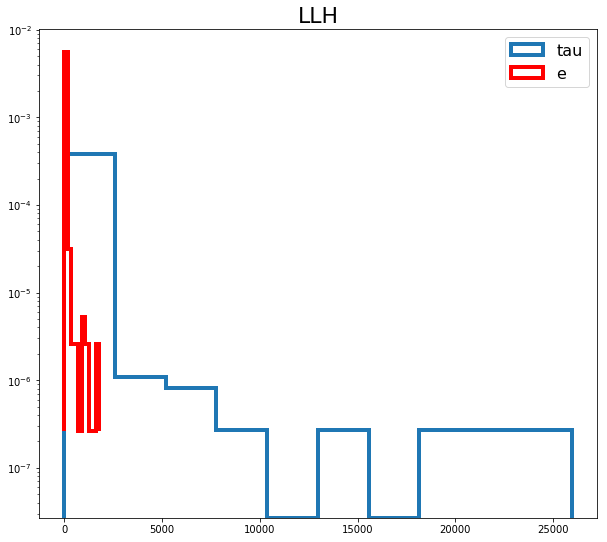

In [30]:
plt.figure(figsize=(10,9))
plt.hist((LRR_t[LRR_t < 200000]), normed=True, log=True, histtype='step', linewidth=4, label='tau')
plt.hist((LRR_e[LRR_e < 200000]), normed=True, log=True, histtype= 'step', linewidth=4, color='r', label='e')
plt.legend(fontsize=16)
plt.title('LLH', fontsize = 22)

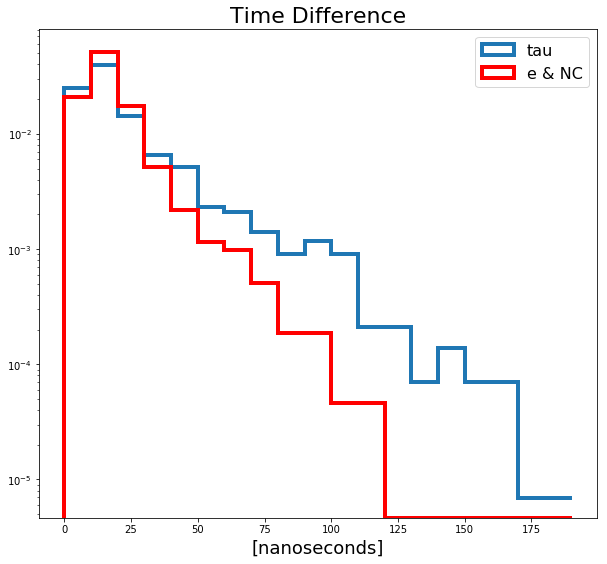

In [34]:
plt.figure(figsize=(10,9))
bins_tdiff = np.arange(0, 200, 10)
plt.hist(timeDifferences_t, bins = bins_tdiff, normed=True, log=True, histtype='step', linewidth=4, label='tau')
plt.hist(timeDifferences_e, bins = bins_tdiff, normed=True, log=True, histtype= 'step', linewidth=4, color='r', label='e & NC')
plt.legend(fontsize=16)
plt.title('Time Difference', fontsize = 22)
plt.xlabel('[nanoseconds]', fontsize = 18)

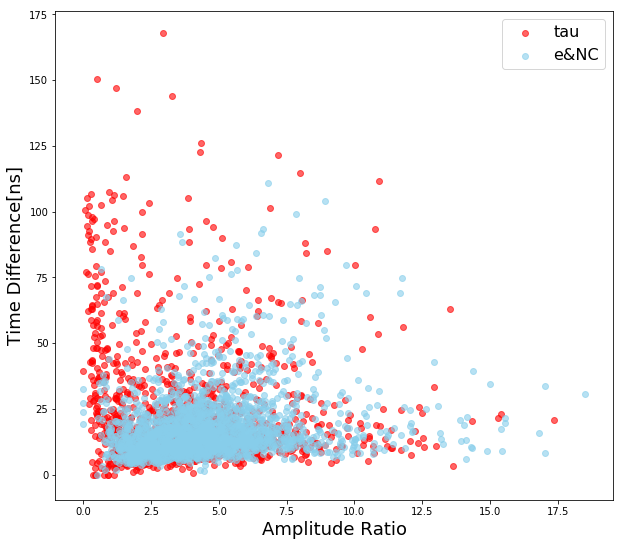

In [38]:
plt.figure(figsize=(10,9))
plt.scatter(no.log10(ampRatio_t[ampRatio_t < 2e12]), timeDifferences_t[ampRatio_t < 2e12], label='tau', c ='r', alpha = 0.6)
plt.scatter(ampRatio_e[ampRatio_e < 2e12], timeDifferences_e[ampRatio_e < 2e12], label='e&NC', c='skyblue', alpha = 0.6)
plt.legend(fontsize=16)
plt.xlabel('Amplitude Ratio', fontsize = 18)
plt.ylabel('Time Difference[ns]', fontsize = 18)

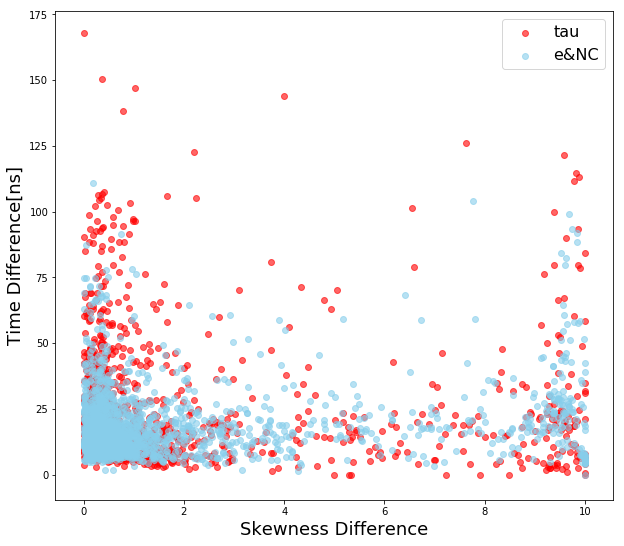

In [39]:
plt.figure(figsize=(10,9))
plt.scatter(skewnessRatio_t, timeDifferences_t, label='tau', c ='r', alpha = 0.6)
plt.scatter(skewnessRatio_e, timeDifferences_e, label='e&NC', c='skyblue', alpha = 0.6)
plt.legend(fontsize=16)
plt.xlabel('Skewness Difference', fontsize = 18)
plt.ylabel('Time Difference[ns]', fontsize = 18)

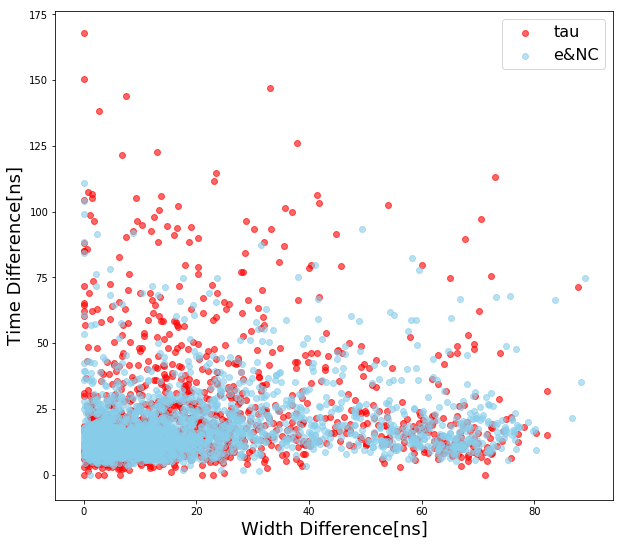

In [40]:
plt.figure(figsize=(10,9))
plt.scatter(widthRatio_t, timeDifferences_t, label='tau', c ='r', alpha = 0.6)
plt.scatter(widthRatio_e, timeDifferences_e, label='e&NC', c='skyblue', alpha = 0.6)
plt.legend(fontsize=16)
plt.xlabel('Width Difference[ns]', fontsize = 18)
plt.ylabel('Time Difference[ns]', fontsize = 18)

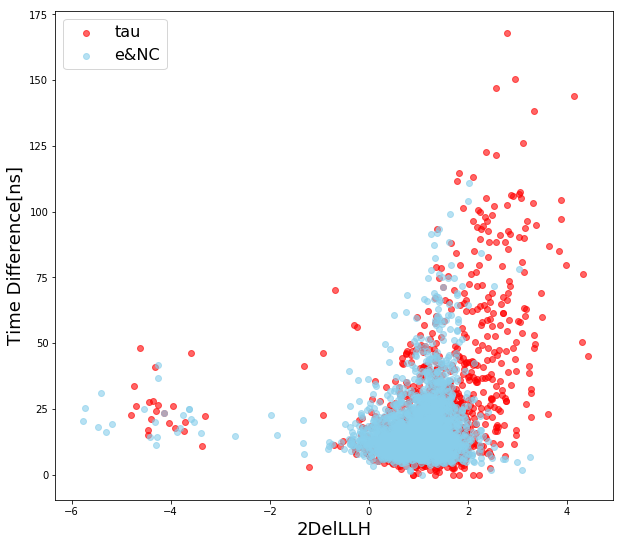

In [19]:
plt.figure(figsize=(10,9))
plt.scatter(np.log10(LRR_t[(LRR_t > -1e12)]), timeDifferences_t[(LRR_t > -1e12)], label='tau', c ='r', alpha = 0.6)
plt.scatter(np.log10(LRR_e[(LRR_e > -1e12)]), timeDifferences_e[(LRR_e > -1e12)], label='e&NC', c='skyblue', alpha = 0.6)
plt.legend(fontsize=16)
plt.xlabel('2DelLLH', fontsize = 18)
plt.ylabel('Time Difference[ns]', fontsize = 18)

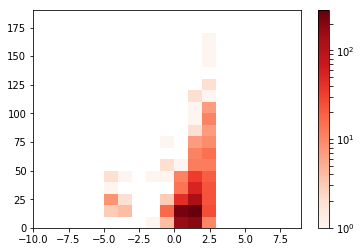

In [63]:
from matplotlib.colors import LogNorm
binsX = np.arange(0, 200, 10)
binsY = np.arange(-10, 10, 1)
plt.hist2d(np.log10(LRR_t[(LRR_t < 1e3)]),timeDifferences_t[(LRR_t <1e3)], bins=(binsY,binsX), cmap='Reds', norm=LogNorm())
plt.colorbar()

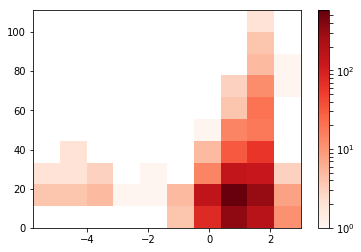

In [53]:
plt.hist2d(np.log10(LRR_e[(LRR_e < 1e3)]), timeDifferences_e[(LRR_e < 1e3)], cmap='Reds', norm=LogNorm())
plt.colorbar()

In [64]:
def s(r = False):
    if r == True:
        print('true')

In [67]:
s(r=True)

true


In [ ]:
if wRatio > 50:
                    
                    '''
                    Calculating the mean and removing the tails
                    '''

                    #mean = recoPulse_timeList.mean()
                    mean = sum(recoPulse_timeList*recoPulse_chargeList)/sum(recoPulse_chargeList) #mean is weighted
                    select_time = recoPulse_timeList[(recoPulse_timeList > mean-50) & (recoPulse_timeList < mean+50)]
                    select_charge = recoPulse_chargeList[(recoPulse_timeList > mean-50) & (recoPulse_timeList < mean+50)]
                    #print('SELECT CHARGE', select_charge, select_time, mean, recoPulse_timeList, recoPulse_chargeList)

                    if len(select_time) < 10:
                        continue

                    mean_select_time = sum(select_time*select_charge)/sum(select_charge)
                    max_hitTimes = recoPulse_timeList[(recoPulse_timeList > (mean_select_time-100))&(recoPulse_timeList < (mean_select_time+100))]
                    max_charge = recoPulse_chargeList[(recoPulse_timeList > (mean_select_time-100))&(recoPulse_timeList < (mean_select_time+100))]

                    if len(max_hitTimes) < 10:
                        continue

                    #Shifting mean to zero
                    max_hitTimes_mean = sum(max_hitTimes*max_charge)/sum(max_charge)
                    timestamps = max_hitTimes - max_hitTimes_mean
                    final_mean = sum(timestamps*max_charge)/sum(max_charge)

                    '''
                    Histogramming the data from simulation
                    '''
                    print('Now Histogramming')
                    bins = np.arange(min(timestamps), max(timestamps), 3)
                    num, bin_edges = np.histogram(timestamps, bins=bins, weights=max_charge)
                    bin_centers = (bin_edges[:-1]+bin_edges[1:])/2

                    num_ampRatio = num/max(num)

                    #removing bins which are <1/5 the max(num), removing the tails this way.
                    entries_in_bins = num[num_ampRatio > 0.2]
                    bin_centers = bin_centers[num_ampRatio > 0.2]
            
                    if max(bin_centers) <= 0:
                        maxBinCenter = max(bin_centers) + abs(max(bin_centers)) + 3
                        continue
                    else:
                        maxBinCenter = max(bin_centers)
                        
                    '''
                    (x, y) values for the fit
                    '''
                    #x = bin_centers
                    x = np.linspace(min(bin_centers)-30, max(bin_centers)+30, 1000)
                    y_biGauss = biGauss(x, vals_single[1], vals_single[2], vals_single[3], vals_single[4])
                    y_doublePeak = double_peak(x, vals[1], vals[2], vals[3], vals[4], 
                                               vals[5], vals[6], vals[7], vals[8])
                        
                    plt.figure(figsize=(10,9))
                    _ = plt.hist(timestamps, bins=bins, weights=max_charge, histtype='step')
                    plt.plot(x, y_biGauss, '-', c = 'k')
                    plt.plot(x, y_doublePeak, '-', c = 'r')
                    plt.axvline(x=vals[1], c='g')
                    plt.axvline(x=vals[5], c='g')
                    plt.axhline(y=vals[4], c='g')
                    plt.axhline(y=vals[8], c='g')
                    plt.title('Time Difference - ' +str(tDiff) + ' File_num -' + str(i)

In [32]:
data.shape

(2, 3255)

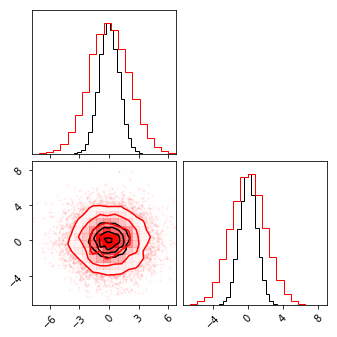

In [17]:
ndim, nsamples = 2, 10000
np.random.seed(42)
samples = np.random.randn(ndim * nsamples).reshape([nsamples, ndim])
figure = corner.corner(samples)
corner.corner(samples * 2, fig=figure, color='red')
plt.show()

In [18]:
samples.shape

(10000, 2)

In [30]:
data1.shape

(2604, 2)

In [27]:
arr = np.zeros(5)

In [28]:
arr[0] = timeDifferences_t

ValueError: setting an array element with a sequence.